# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) (IN2375) Exercise

In this exercise we provide you with a baseline multi-object tracker on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. Your task is to improve its tracking performance by applying different techniques from the lecture. As most modern multi-object trackers, the provided baseline follows the tracking-by-detection paradigm. To this end, an object detector is applied to each frame indepdently and in a subsequent data association step the detections are combined to tracks over multiple frames. The challenge is to connect the correct detections of the same object and produce identity preserving tracks.

The improvement on the provided baseline tracker can be achieved in multiple ways:

*   Improving the object detector.
*   Improving the tracker (data association step).
*   Incorporating segmentation information.



## Setup

### Download and extract project data to your Google Drive

1.   Install Google Drive on your desktop.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/u/meinhard/cv3dst_exercise.zip) zip file to your desktop and extract it into the `Colab Notebooks` folder in your Google Drive.
4.   Wait until Google Drive finished the synchronisation. (This might take a while.)


#### Connect the notebook to your Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"

The `root_dir` path points to the directory and the content in your Google Drive.

In [0]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/tracker"

data  models  output  src
data_obj_detect.py  __init__.py		__pycache__  utils.py
data_track.py	    object_detector.py	tracker.py


#### Install and import Python libraries

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

     |████████████████████████████████| 1.5MB 5.1MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp36-cp36m-linux_x86_64.whl size=1589004 sha256=171b979b6f33053c38ca9928bcc2005e72706aa185fc71986e4849c8f0c5cf32
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap
     / 737kB 101.9MB/s
  Created wheel for motmetrics: filename=motmetrics-1.1.3-cp36-none-any.whl size=134191 sha256=1e1f93b0f8cbcfc9b9e598201e18b58b4d28739dc91bc98e598ce3c8b3cb833f
  Stored in directory: /tmp/pip-ephem-wheel-cache-6we49z5m/wheels/c9/e9/0a/79599df270874df0ab21a57a729e8a956aed3c744da3397efc
Successfully built motmetrics


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

import motmetrics as mm
mm.lap.default_solver = 'lap'

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.

At this point the test set directort is still empty. Later in the semester we will provide you with the necesssary test sequences to submit to our challenge.

In [5]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-08  MOT16-12


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

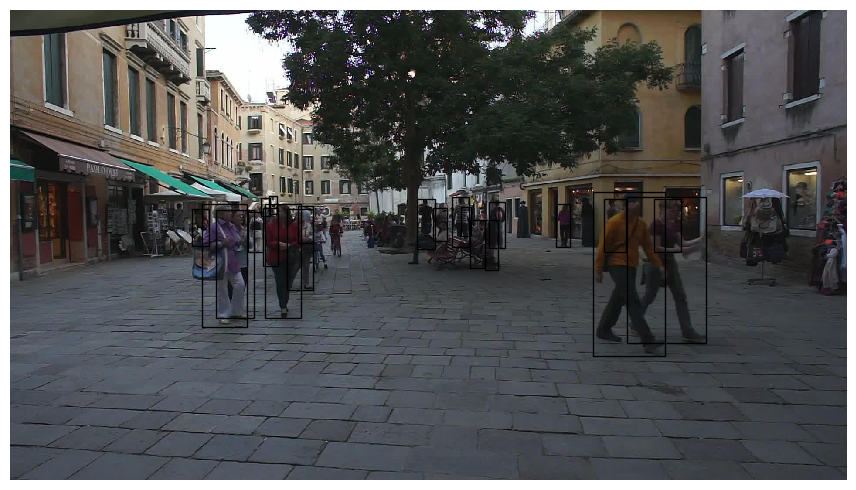

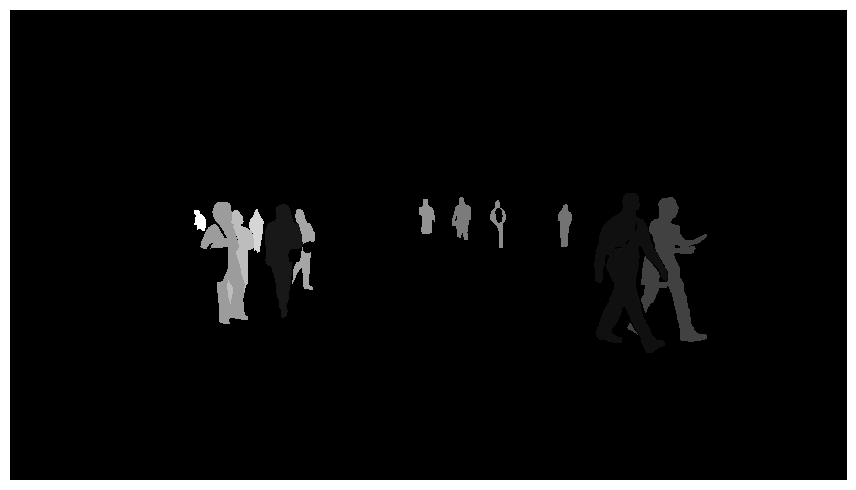

In [0]:
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        if 'seg_img' in frame:
            seg_img = frame['seg_img']
            fig, ax = plt.subplots(1, dpi=dpi)
            fig.set_size_inches(width / dpi, height / dpi)
            ax.imshow(seg_img, cmap='gray')
            plt.axis('off')
            plt.show()
        break

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [0]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model



## Configuration

In [0]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = .4

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)

FRCNN_FPN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
        

If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:

`AP: 0.8677356206210984 Prec: 0.9220907182151947 Rec: 0.9167998134001982 TP: 78611.0 FP: 6642.0`

In [0]:
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'),
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

#evaluate_obj_detect(obj_detect, data_loader_test)

In [0]:
nms .1 AP: 0.761085472023301 Prec: 0.949875423420397 Rec: 0.7914280716076739 TP: 67861.0 FP: 3581.0
nms .3 AP: 0.8630279998611184 Prec: 0.9220907182151947 Rec: 0.9167998134001982 TP: 78611.0 FP: 6642.0
nms .35 AP: 0.8690842382637716 Prec: 0.9119246145059966 Rec: 0.9311213481835675 TP: 79839.0 FP: 7711.0
nms .4 AP: 0.869615175302283 Prec: 0.8984259413760498 Rec: 0.9419091492215289 TP: 80764.0 FP: 9131.0 
nms .5 AP: 0.8420875654278465 Prec: 0.8510143415906127 Rec: 0.9515540264738469 TP: 81591.0 FP: 14284.0
nms 1  AP: 0.15384306867442613 Prec: 0.1450720901067915 Rec: 0.8688320018659981 TP: 74498.0 FP: 439026.0

# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

Try to understand the baseline tracker and think of ideas on how to improve it with the knowledge from the lecture or even beyond.

## Configuration

In [0]:
seed = 12345
seq_name = 'MOT16-test'
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

## Setup

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)

# tracker
class TrackerIoUAssignment(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)

            #update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            #add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)
        
class HungarianTrackerIoUAssignment(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)
 
            # find the assignment using Hugarian algo
            tracks_box_ind = mm.lap.linear_sum_assignment(distance)
            tracks_ind, boxes_ind = np.array(tracks_box_ind)

            # update existing tracks
            keep = []
            for i in range(len(tracks_ind)):
                self.tracks[tracks_ind[i]].box = boxes[boxes_ind[i]]
                keep.append(self.tracks[tracks_ind[i]].id)

            self.tracks = [t for t in self.tracks
                           if t.id in keep]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, box in enumerate(boxes):
                if i not in boxes_ind:
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)

tracker = HungarianTrackerIoUAssignment(obj_detect)

## Run tracker

In [11]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-01



No GT evaluation data available.
Tracks found: 209
Runtime for MOT16-01: 194.3 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-01.txt
Tracking: MOT16-03



No GT evaluation data available.
Tracks found: 733
Runtime for MOT16-03: 883.3 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-03.txt
Tracking: MOT16-12



No GT evaluation data available.
Tracks found: 266
Runtime for MOT16-12: 503.5 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-12.txt
Tracking: MOT16-08



No GT evaluation data available.
Tracks found: 302
Runtime for MOT16-08: 296.1 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-08.txt
Runtime for all sequences: 1877.2 s.


In [0]:
.5 nms, hungarian algo
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML    FP    FN  IDs    FM  MOTA  MOTP
MOT16-11 57.2% 60.8% 54.0% 81.3% 91.5%  75  44  25  6   714  1769  158    61 72.0% 0.083 286
MOT16-10 28.2% 26.7% 29.9% 83.8% 75.0%  57  39  17  1  3586  2078  995   211 48.1% 0.156 697
MOT16-04 68.5% 76.6% 61.9% 78.5% 97.1%  83  44  28 11  1113 10233  179   185 75.8% 0.103 349
MOT16-09 47.5% 55.6% 41.4% 70.8% 95.3%  26  14  11  1   188  1554   79    72 65.8% 0.093 118
MOT16-05 52.0% 58.5% 46.9% 71.6% 89.3% 133  63  59 11   594  1962  249   141 59.4% 0.145 300
MOT16-13 37.3% 34.5% 40.5% 89.0% 76.0% 110  88  21  1  3277  1284 1112   208 51.3% 0.144 545
MOT16-02 34.5% 44.9% 28.0% 55.3% 88.8%  62  14  37 11  1295  8309  402   225 46.1% 0.096 337
OVERALL  51.6% 56.0% 47.9% 75.8% 88.8% 546 306 198 42 10767 27189 3174  1103 63.4% 0.114

Test
1 266
3 998
12 303
8 376
===========================================================================================
BEST
.35 nms, hungarian algo
Test
1 209 tracks
3 733 tracks
12 266
8 302

Hungarian algo
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs    FM  MOTA  MOTP
MOT16-11 59.8% 65.6% 55.0% 80.7% 96.2%  75  44  24  7  299  1825   98    75 76.5% 0.083 166
MOT16-10 35.0% 36.1% 33.9% 81.6% 87.1%  57  39  17  1 1549  2357  543   242 65.3% 0.151 397
MOT16-04 66.6% 76.5% 59.0% 75.5% 98.0%  83  40  31 12  744 11628  188   244 73.6% 0.101 214
MOT16-09 48.5% 59.1% 41.2% 68.1% 97.7%  26  13  12  1   87  1701   61    64 65.3% 0.082 70
MOT16-05 53.9% 62.9% 47.2% 70.1% 93.6% 133  56  66 11  332  2066  177   138 62.8% 0.143 219
MOT16-13 51.6% 51.5% 51.6% 86.6% 86.5% 110  85  22  3 1573  1560  515   199 68.7% 0.138 376
MOT16-02 39.3% 54.8% 30.7% 53.2% 95.2%  62  13  37 12  496  8690  233   202 49.3% 0.096 226
OVERALL  54.8% 62.5% 48.8% 73.4% 94.2% 546 290 209 47 5080 29827 1815  1164 67.3% 0.111

        IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP    FN  IDs    FM  MOTA  MOTP
MOT16-05 53.9% 62.9% 47.2% 70.1% 93.6% 133 56 66 11 332 2066 177  138 62.8% 0.143 219
MOT16-02 39.3% 54.8% 30.7% 53.2% 95.2% 62 13 37 12 496 8690 233  202 49.3% 0.096 226

wrong impln
MOT16-02 16.0% 28.8% 11.1% 36.8% 95.9% 62  2 41 19 293 11745 3010  3001 19.0% 0.083 3290, 5093, 2330, 1039, 6920, 5187, 3238,
OVERALL  16.0% 28.8% 11.1% 36.8% 95.9% 62  2 41 19 293 11745 3010  3001 19.0% 0.083

=========================================================================================
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML    FP    FN IDs   FM  MOTA  MOTP
MOT16-11 49.2% 54.6% 44.8% 55.5% 67.6%  75  16  33  26  2504  4201  19   32 28.7% 0.080 64
MOT16-10 33.9% 38.3% 30.4% 41.9% 52.9%  57  12  26  19  4792  7456  63  122  4.1% 0.139 89
MOT16-04 59.5% 60.1% 58.9% 67.3% 68.7%  83  28  37  18 14597 15541  61  150 36.5% 0.111 121
MOT16-09 45.4% 51.6% 40.6% 55.7% 70.8%  26   8  13   5  1220  2360  36   59 32.1% 0.109 38
MOT16-05 49.1% 54.8% 44.4% 59.1% 72.9% 133  39  65  29  1518  2831  85   99 35.9% 0.145 165
MOT16-13 46.6% 62.9% 37.0% 44.5% 75.6% 110  27  33  50  1671  6458  90  127 29.4% 0.135 118
MOT16-02 32.8% 51.2% 24.1% 30.8% 65.2%  62   5  23  34  3047 12864  50   84 14.1% 0.085 50
OVERALL  49.6% 55.8% 44.7% 54.0% 67.4% 546 135 230 181 29349 51711 404  673 27.5% 0.113

The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT17-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT17-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT17-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT17-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT17-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT17-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT17-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

For your final submission you should focus on improving `MOTA`.

## Visualize tracking results

In [14]:
plot_sequence(results_seq['MOT16-01'],
              [s for s in sequences if str(s) == 'MOT16-01'][0],
              first_n_frames=10)

Output hidden; open in https://colab.research.google.com to view.

# Notes and next steps

*   Experiment and debug on a single train sequence. If something works on a single sequence evaluate all train sequences to check the generaliztion of your improvement.
*   Remember to split the training set into multiple sets with different sequences if you train something and want to avoid overfitting.
*   Sometimes the execution of a cell gets stuck. If this happends just abort the execution and restart the cell.
*   If the notebook warns you that currently no GPU hardware acceleration is available, try again later and focus on some debugging or experiments than can be done only with the CPU.
* Try to improve your results on your local train/validation splits before submitting to our test servers. The submission will be limited to avoid overfitting to the test sequences.


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences and upload the zipped prediction files to our server. More information on this will follow.

We will make the test sequences and minimum `MOTA` for receiving the exam bonus available by the end of december.

In [0]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/"

MOT16-01.txt  MOT16-04.txt  MOT16-09.txt  MOT16-12.txt
MOT16-02.txt  MOT16-05.txt  MOT16-10.txt  MOT16-13.txt
MOT16-03.txt  MOT16-08.txt  MOT16-11.txt
